# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eiffel.core.results import Results

res = Results.from_path(
    "/Users/leo/Workspace/phdcybersec/fl-ids/exps/assessment/results/sampled/hyperparams/+distribution=5-5,+epochs=100_1x100,+scenario=continuous-100,+target=untargeted,batch_size=32,datasets=nfv2_sampled_cicids,partitioner=iid,seed=327/"
).scope("global")

## RQ0: Is the behavior predictable?

A preliminary question to solve is how predictable is the behavior of the attack propagation, given a scenario and a distribution; *ie.*, how scattered are the results at a given point in time, for different seeds.

### Test methodology

Test a set of different seeds on: 5/5, continuous-100. Plot:
- mean
- standard deviation (envelope mean-std, mean+std)
- min/max

**Seeds list**: 1138, 421, 1313, 5555, 6567, 327, 2187, 1977, 501, 3263827

In [3]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("results/sampled/hyperparams/"))

Key,Values
distribution,5-5
epochs,"100_10x10, 100_4x25, 100_1x100"
scenario,"continuous-100, late-3"
target,untargeted
batch_size,"128, 32, 512"
datasets,nfv2_sampled_cicids
partitioner,iid
seed,"1313, 327, 1138, 1977, 3263827, 421, 501, 2187, 5555, 6567"


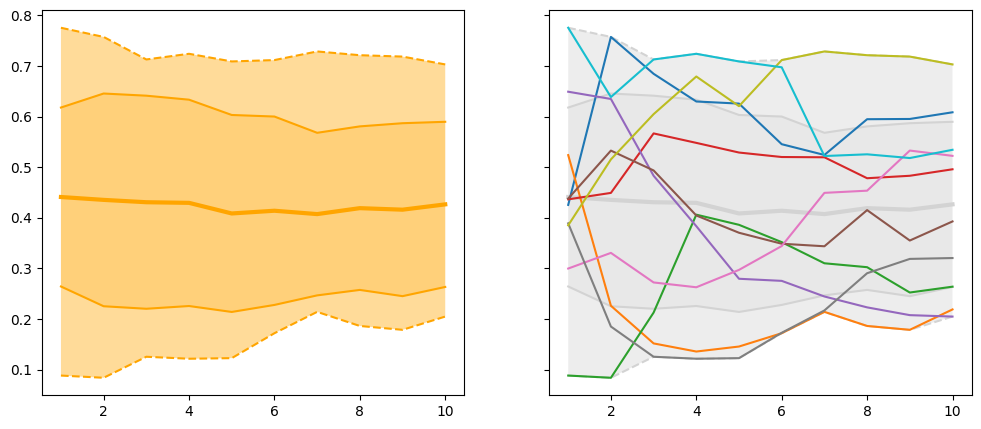

In [4]:
import re

from eiffel.analysis.metrics import average, search_metrics
from eiffel.analysis.plot import Plotable, envelope
from matplotlib import pyplot as plt


def _process(s: str) -> Plotable:
    dist = Results.from_path(s).scope("global").distributed
    return Plotable(s, average(dist).metric("accuracy"))


plotables = list(
    map(
        _process,
        search_metrics(
            "results/sampled/hyperparams",
            scenario="continuous-100",
            target="untargeted",
            batch_size="512",
            distribution="5-5",
            epochs=".*10x.*",
            datasets=".*cicids",
        ),
    )
)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

envelope(plotables, axs[0])
envelope(plotables, axs[1], color="lightgrey")

for plotable in plotables:
    seed = re.search(r"seed=(\d+)", plotable.name).group(1)
    axs[1].plot(
        range(1, len(plotable.values) + 1),
        plotable.values,
        label=f"seed={seed}",
    )

### Observations

- A 100% continuous attack perpetrated by 50% of the nodes produces **in average** a 50% detection rate.
- Over ten runs, the results are very sparse: the standard deviation is very high, and the min/max values are very far from the mean.

The results *tend* to confirm the expected hypotheses **in average**. However, it is difficult to predict the behavior of one specific attack.
The results of further analyses (RQ1-4) must be interpreted with this in mind.

**THEREFORE**: While the results of existing defense mechanisms are not to be discarded, such unpredictability might mean that some specific attacks might bypass them if they are not designed to be robust to such variations.

## RQ1: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?

- look at all variations of hyperparameters: `["batch_size", "epochs"]`; learning rate does not need to be tested as Adam (optimizer) has an adaptive learning rate.
	- all curves on one plot
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
	- scenario `continuous-100`
- distribution `10-0` and `5-5`
- do it twice for untargeted vs targeted
- do the same for `late-3` to see the impact of previous training

In [5]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam/",
            scenario="continuous-100",
            target="untargeted",
            batch_size="32",
            distribution="5-5",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam/",
            scenario="continuous-100",
            target="untargeted",
            batch_size="64",
            distribution="5-5",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam/",
            scenario="continuous-100",
            target="untargeted",
            batch_size="128",
            distribution="5-5",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam/",
            scenario="continuous-100",
            target="untargeted",
            batch_size="256",
            distribution="5-5",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam/",
            scenario="continuous-100",
            target="untargeted",
            batch_size="512",
            distribution="5-5",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)

NameError: name 'plot' is not defined

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
)
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/hyperparam",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
)

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="f1",
    ),
)
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="1e",
            datasets=".*nb15",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="4e",
            datasets=".*nb15",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="10e",
            datasets=".*nb15",
        ),
        metric="f1",
    ),
)

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            datasets=".*cicids",
        ),
    ),
)

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            datasets=".*nb15",
        ),
    ),
)

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            datasets=".*cicids",
        ),
    ),
)

In [ ]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            datasets=".*nb15",
        ),
    ),
)